---
# Loading Libraries & Modules
---

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageOps
from rembg.bg import remove

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img

2023-05-01 06:16:33.342598: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 06:16:33.344483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 06:16:33.383969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 06:16:33.384658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 06:16:34.094730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn.functional import relu
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import transforms

In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

---
# Dataset generation
---

In [6]:
leagues_path = 'top-5-football-leagues'
leagues = os.listdir(leagues_path)

leagues_dict = dict()

for league in leagues:
    league_path = os.path.join(leagues_path, league)
    teams = os.listdir(league_path)

    for each in range(len(teams)):
        teams[each] = teams[each].replace('.png', '')

    leagues_dict[league] = teams

print(leagues_dict)

{'bundesliga': ['augsburg', 'bayern', 'bremen', 'dortmund', 'dusseldorf', 'frankfurt', 'freiburg', 'furth', 'hamburg', 'hannover', 'hertha-bsc-berlin', 'hoffenheim', 'leverkusen', 'mainz', 'moenchengladbach', 'nuremberg', 'redbull-leipzig', 'schalke', 'stuttgart', 'wolfsburg'], 'french-ligue1': ['angers-sco', 'as-monaco', 'as-saint-etienne', 'clermont-foot-63', 'estac-troyes', 'fc-girondins-de-bordeaux', 'fc-lorient', 'fc-metz', 'fc-nantes', 'losc-lille', 'montpellier-herault', 'ogc-nice', 'olympique-de-marseille', 'olympique-lyonnais', 'paris-saint-germain', 'rc-lens', 'rc-strasbourg-alsace', 'stade-brestois-29', 'stade-de-reims', 'stade-rennais-fc'], 'la-liga': ['athletic', 'atletico-madrid', 'barcelona', 'cadiz', 'celta', 'deportivo-alavez', 'elche', 'espanyol', 'getafe', 'granada', 'levante', 'mallorca', 'osasuna', 'rayo-vallecano', 'real-betis', 'real-madrid', 'real-sociedad', 'sevilla', 'valencia', 'villarreal'], 'premier-league': ['arsenal', 'aston-villa', 'brentford', 'brighton

## Augmenting images

In [7]:
image_augmentor = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='constant'
)

## Specifying dataset configurations

In [8]:
DATASET_FOLDER = 'generated_dataset'

In [9]:
IMAGE_PATHS = []
LABELS = []

In [10]:
# image size
IMG_SIZE = 64
# number of the images to be generated for each team
NUM_IMAGES = 75

## Function to generate images

In [11]:
def gen_images(final_dataset_path, league, team, team_image, num_images, image_size):
    if not os.path.exists(final_dataset_path):
        os.mkdir(final_dataset_path)
    
    league_path = os.path.join(final_dataset_path, league)
    if not os.path.exists(league_path):
        os.mkdir(league_path)
    
    team_path = os.path.join(league_path, team)
    if not os.path.exists(team_path):
        os.mkdir(team_path)
    
    num = 0
    for batch in image_augmentor.flow(team_image, batch_size=1, save_to_dir=team_path, save_prefix=team, save_format='jpeg'):
        num += 1
        if num >= num_images:
            break
        
    # renaming generated images
    for count, file_name in enumerate(os.listdir(team_path)):
        source = os.path.join(team_path, file_name)
        destination = os.path.join(team_path, f'{team}-{count}.jpeg')
        os.rename(source, destination)
    
    # appending paths and labels
    for file_name in os.listdir(team_path):
        image_path = os.path.join(team_path, file_name)
        IMAGE_PATHS.append(image_path)
        LABELS.append(team)


## Image generation loop

In [12]:
for each_league in leagues_dict.keys():
    each_league_path = os.path.join(leagues_path, each_league)
    each_league_teams = leagues_dict[each_league]
    
    for each_team in each_league_teams:
        # resizing the image
        img = cv2.imread(os.path.join(each_league_path, f'{each_team}.png'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        resized_img = resized_img.reshape((1,) + resized_img.shape)
        
        # generating images
        gen_images(DATASET_FOLDER, each_league, each_team, resized_img, NUM_IMAGES, IMG_SIZE)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [13]:
total = 0

for league in os.listdir(DATASET_FOLDER):
    l_path = os.path.join(DATASET_FOLDER, league)
    for team in os.listdir(l_path):
        t_path = os.path.join(l_path, team)
        nums = len(os.listdir(t_path))
        if nums < NUM_IMAGES:
            print(f'team:{team}, missing:{NUM_IMAGES-nums}')
        total += nums

print('-'*50)        
print(f'total images generated: {total}/{100*NUM_IMAGES}')

team:leverkusen, missing:1
team:nuremberg, missing:3
team:wolfsburg, missing:1
team:losc-lille, missing:2
team:olympique-lyonnais, missing:1
team:stade-de-reims, missing:1
team:granada, missing:1
team:osasuna, missing:1
team:real-betis, missing:1
team:real-madrid, missing:1
team:real-sociedad, missing:1
team:villarreal, missing:1
team:aston-villa, missing:1
team:manchester-city, missing:1
team:tottenham-hotspur, missing:1
team:ac-milan, missing:1
team:roma, missing:1
team:salernitana, missing:1
team:sampdoria, missing:1
--------------------------------------------------
total images generated: 7478/7500


In [14]:
classes = np.unique(LABELS)

_label = 0
classes_dict = {}
for each in classes:
    classes_dict[each] = _label
    _label += 1
    
classes_dict

{'ac-milan': 0,
 'angers-sco': 1,
 'arsenal': 2,
 'as-monaco': 3,
 'as-saint-etienne': 4,
 'aston-villa': 5,
 'atalanta': 6,
 'athletic': 7,
 'atletico-madrid': 8,
 'augsburg': 9,
 'barcelona': 10,
 'bayern': 11,
 'bologna': 12,
 'bremen': 13,
 'brentford': 14,
 'brighton': 15,
 'burnley': 16,
 'cadiz': 17,
 'cagliari': 18,
 'celta': 19,
 'chelsea': 20,
 'clermont-foot-63': 21,
 'crystal-palace': 22,
 'deportivo-alavez': 23,
 'dortmund': 24,
 'dusseldorf': 25,
 'elche': 26,
 'empoli': 27,
 'espanyol': 28,
 'estac-troyes': 29,
 'everton': 30,
 'fc-girondins-de-bordeaux': 31,
 'fc-lorient': 32,
 'fc-metz': 33,
 'fc-nantes': 34,
 'fiorentina': 35,
 'frankfurt': 36,
 'freiburg': 37,
 'furth': 38,
 'genoa': 39,
 'getafe': 40,
 'granada': 41,
 'hamburg': 42,
 'hannover': 43,
 'hellas-verona': 44,
 'hertha-bsc-berlin': 45,
 'hoffenheim': 46,
 'inter': 47,
 'juventus': 48,
 'lazio': 49,
 'leeds-united': 50,
 'leicester-city': 51,
 'levante': 52,
 'leverkusen': 53,
 'liverpool': 54,
 'losc-lill

In [15]:
classes_reverse_dict = {}
for key, val in classes_dict.items():
    classes_reverse_dict[val] = key
    
classes_reverse_dict

{0: 'ac-milan',
 1: 'angers-sco',
 2: 'arsenal',
 3: 'as-monaco',
 4: 'as-saint-etienne',
 5: 'aston-villa',
 6: 'atalanta',
 7: 'athletic',
 8: 'atletico-madrid',
 9: 'augsburg',
 10: 'barcelona',
 11: 'bayern',
 12: 'bologna',
 13: 'bremen',
 14: 'brentford',
 15: 'brighton',
 16: 'burnley',
 17: 'cadiz',
 18: 'cagliari',
 19: 'celta',
 20: 'chelsea',
 21: 'clermont-foot-63',
 22: 'crystal-palace',
 23: 'deportivo-alavez',
 24: 'dortmund',
 25: 'dusseldorf',
 26: 'elche',
 27: 'empoli',
 28: 'espanyol',
 29: 'estac-troyes',
 30: 'everton',
 31: 'fc-girondins-de-bordeaux',
 32: 'fc-lorient',
 33: 'fc-metz',
 34: 'fc-nantes',
 35: 'fiorentina',
 36: 'frankfurt',
 37: 'freiburg',
 38: 'furth',
 39: 'genoa',
 40: 'getafe',
 41: 'granada',
 42: 'hamburg',
 43: 'hannover',
 44: 'hellas-verona',
 45: 'hertha-bsc-berlin',
 46: 'hoffenheim',
 47: 'inter',
 48: 'juventus',
 49: 'lazio',
 50: 'leeds-united',
 51: 'leicester-city',
 52: 'levante',
 53: 'leverkusen',
 54: 'liverpool',
 55: 'losc-

## Saving the generated data as a CSV

In [16]:
df = pd.DataFrame({'image_path': IMAGE_PATHS, 'label': LABELS})

In [17]:
df

,image_path,label
0,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
1,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
2,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
3,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
4,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
...,...,...
7473,generated_dataset/serie-a/venezia/venezia-72.jpeg,venezia
7474,generated_dataset/serie-a/venezia/venezia-73.jpeg,venezia
7475,generated_dataset/serie-a/venezia/venezia-74.jpeg,venezia
7476,generated_dataset/serie-a/venezia/venezia-8.jpeg,venezia


In [18]:
df.to_csv('dataset_paths.csv', index=False)

---
# Loading the dataset
---

In [19]:
teams_df = pd.read_csv('dataset_paths.csv')

In [20]:
teams_df

,image_path,label
0,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
1,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
2,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
3,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
4,generated_dataset/bundesliga/augsburg/augsburg...,augsburg
...,...,...
7473,generated_dataset/serie-a/venezia/venezia-72.jpeg,venezia
7474,generated_dataset/serie-a/venezia/venezia-73.jpeg,venezia
7475,generated_dataset/serie-a/venezia/venezia-74.jpeg,venezia
7476,generated_dataset/serie-a/venezia/venezia-8.jpeg,venezia


In [21]:
num_datapoints = teams_df.shape[0]
num_datapoints

7478

## Plotting image from the dataset

In [22]:
transform = transforms.Compose([transforms.ToTensor()])

In [23]:
def dataset_image_show(index):
    plt.imshow(transform(load_img(teams_df['image_path'][index])).permute(1, 2, 0))
    plt.title(teams_df['label'][index])
    plt.show()

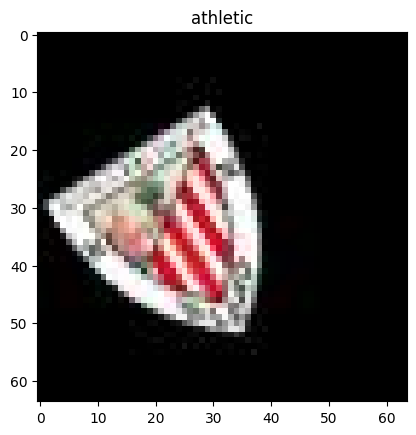

In [24]:
dataset_image_show(3000)

## Encoding labels

In [25]:
for each in range(num_datapoints):
    teams_df['label'][each] = classes_dict[teams_df['label'][each]]

In [26]:
teams_df

,image_path,label
0,generated_dataset/bundesliga/augsburg/augsburg...,9
1,generated_dataset/bundesliga/augsburg/augsburg...,9
2,generated_dataset/bundesliga/augsburg/augsburg...,9
3,generated_dataset/bundesliga/augsburg/augsburg...,9
4,generated_dataset/bundesliga/augsburg/augsburg...,9
...,...,...
7473,generated_dataset/serie-a/venezia/venezia-72.jpeg,94
7474,generated_dataset/serie-a/venezia/venezia-73.jpeg,94
7475,generated_dataset/serie-a/venezia/venezia-74.jpeg,94
7476,generated_dataset/serie-a/venezia/venezia-8.jpeg,94


## Performing train-validation-test split and creating dataloaders

In [27]:
# dataloader function
'''
def data_loader(_dataset, batch_size):
    temp_dataset = _dataset.copy()
    random.shuffle(temp_dataset)
    
    len_dataset = len(temp_dataset)
    
    data_batches = []
    
    temp_size = 0
    while temp_size <= len_dataset:
        if temp_size+batch_size < len_dataset:
            data_batches.append(temp_dataset[temp_size: temp_size+batch_size])
        else:
            data_batches.append(temp_dataset[temp_size: len_dataset])
            break
        temp_size += batch_size
        
    return data_batches
'''
print()
'''
teams_dataloader = data_loader(dataset, batch_size=32)
'''
print()

In [28]:
teams_X = np.array(teams_df['image_path'])
teams_y = np.array(teams_df['label'])

train_X, val_test_X, train_y, val_test_y = train_test_split(teams_X, teams_y, test_size=0.3, random_state=0, stratify=teams_y)
test_X, val_X, test_y, val_y = train_test_split(val_test_X, val_test_y, test_size=0.33, random_state=0, stratify=val_test_y)

In [29]:
train_dataset = []
for index in range(len(train_X)):
    img_tensor = transform(load_img(train_X[index]))
    train_dataset.append([img_tensor, train_y[index]])


val_dataset = []
for index in range(len(val_X)):
    img_tensor = transform(load_img(val_X[index]))
    val_dataset.append([img_tensor, val_y[index]])    


test_dataset = []
for index in range(len(test_X)):
    img_tensor = transform(load_img(test_X[index]))
    test_dataset.append([img_tensor, test_y[index]])

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [31]:
for batch in train_dataloader:
    _x, _y = batch
    print(_x.shape)
    print(_x[0].shape)
    break

torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


## Creating dataloaders with grayscaled images

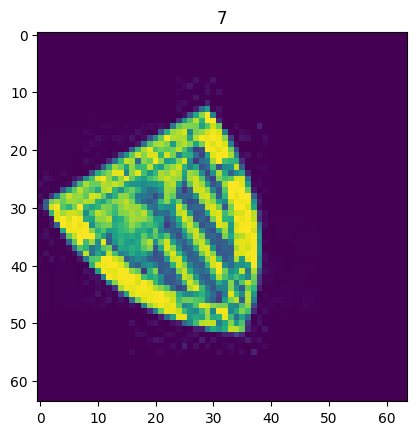

In [32]:
def dataset_image_show_grayscale(index):
    img_gray = ImageOps.grayscale(load_img(teams_df['image_path'][index]))
    plt.imshow(img_gray)
    plt.title(teams_df['label'][index])
    plt.show()
dataset_image_show_grayscale(3000)

In [33]:
train_dataset_gray = []
for index in range(len(train_X)):
    img_tensor = transform(ImageOps.grayscale(load_img(train_X[index])))
    train_dataset_gray.append([img_tensor, train_y[index]])


val_dataset_gray = []
for index in range(len(val_X)):
    img_tensor = transform(ImageOps.grayscale(load_img(val_X[index])))
    val_dataset_gray.append([img_tensor, val_y[index]])   


test_dataset_gray = []
for index in range(len(test_X)):
    img_tensor = transform(ImageOps.grayscale(load_img(test_X[index])))
    test_dataset_gray.append([img_tensor, test_y[index]])

In [34]:
train_dataloader_gray = DataLoader(train_dataset_gray, batch_size=32, shuffle=True)
val_dataloader_gray = DataLoader(val_dataset_gray, batch_size=32, shuffle=True)
test_dataloader_gray = DataLoader(test_dataset_gray, batch_size=32, shuffle=True)

In [35]:
for batch in train_dataloader_gray:
    _x, _y = batch
    print(_x.shape)
    print(_x[0].shape)
    break

torch.Size([32, 1, 64, 64])
torch.Size([1, 64, 64])


---
# Artificial Neural Network (4-Layered Multi Layer Perceptron)
---

In [36]:
class MLP_PyTorch(nn.Module):
    def __init__(self, num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes):
        '''
        Input: numbers of nodes in the layers
        
        Constructor
        '''
        super().__init__()
        self.hidden_layer_1 = nn.Linear(num_input_nodes, num_hidden_nodes_1)
        self.hidden_layer_2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.output_layer = nn.Linear(num_hidden_nodes_2, num_output_nodes)
        
        print('Number of trainable parameters:-')
        for param in self.parameters():
            print(f'{param.numel()}')

    
    def forward(self, x):
        '''
        Input: input layer dataset
        
        Returns the result of forward propagation by the model on the input
        '''
        x = x.reshape(x.shape[0], -1)
        x = relu(self.hidden_layer_1(x))
        x = relu(self.hidden_layer_2(x))
        x = self.output_layer(x)
        
        return x

    
    def save(self, path='best_ann_model.pth'):
        '''
        Saves the model
        '''
        torch.save(self.state_dict(), path)

        
    def load(self, path='best_ann_model.pth'):
        '''
        Loads the model
        '''
        self.load_state_dict(torch.load(path))
        self.eval()
        
        
    def fit(self, train_loader, val_loader,
              optimizer=Adam, loss_function=CrossEntropyLoss(), learning_rate=0.005, epochs=5):
        '''
        Input: Dataloader of the training dataset,
               Dataloader of the validation dataset
               optimizer (default = Adam),
               loss function (default = Cross Entropy loss),
               learning rate for the model (default = 0.005),
               number of epochs (default = 5)
        
        Trains the model, displays the training loss and
        the validation accuracy after each epoch, and
        also saves the best model at the end of each epoch
        '''
        best_accuracy = 0
        worst_loss = float('inf')
        
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        self.loss_func = loss_function
        self.epochs = epochs
        
        self.loss_epochs = list()
        self.acc_epochs = list()
        self.epoch_arr = [each+1 for each in range(self.epochs)]
        
        for epoch in range(self.epochs):
            for batch in train_loader:
                train_X, train_y = batch
                pred_train_y = self.forward(train_X)

                loss = self.loss_func(pred_train_y, train_y)

                # applying backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # checking model performance on the validation set
            total_val_data = len(val_loader.dataset)
            correct_predictions = 0
            for batch in val_loader:
                val_X, val_y = batch
                val_pred_y = self.forward(val_X)
                for each in range(len(val_y)):
                    pred = int(torch.argmax(val_pred_y[each]))
                    true = int(val_y[each])
                    if pred == true:
                        correct_predictions += 1      

            val_acc = correct_predictions / total_val_data

            # epoch-loss
            epoch_loss = loss.item()
            
            # saving the best model
            '''
            if val_acc > best_accuracy:
                best_accuracy = val_accuracy
                self.save()
            '''
            
            if epoch_loss < worst_loss:
                worst_loss = epoch_loss
                self.save()
        
                
            # printing epoch-loss and validation-accuracy of the model    
            self.loss_epochs.append(epoch_loss)
            self.acc_epochs.append(val_acc)
            
            print(f'epoch: {epoch+1}, loss: {epoch_loss}')
            print(f'validation accuracy: {val_acc}')
            print('-'*100)
            
            
    def test(self, test_loader):
        '''
        Input: Dataloader for the testing dataset
        
        Displays the model accuracy on the input
        '''
        # loading the best model
        self.load()
        
        total_test_data = len(test_loader.dataset)
        
        self.test_plot_correct = list()
        self.test_plot_incorrect = list()
        self.test_plot_arr_correct = list()
        self.test_plot_arr_incorrect = list()
        corr_plot_counter = 10
        incorr_plot_counter = 10 
        
        correct_predictions = 0
        for batch in test_loader:
            test_X, test_y = batch
            test_pred_y = self.forward(test_X)

            for each in range(len(test_y)):
                pred = int(torch.argmax(test_pred_y[each]))
                true = int(test_y[each])
                if pred == true:
                    correct_predictions += 1
                    if corr_plot_counter > 0:
                        self.test_plot_correct.append(test_X[each])
                        self.test_plot_arr_correct.append({'actual':true, 'predicted':pred})
                        corr_plot_counter -= 1
                else:
                    if incorr_plot_counter > 0:
                        self.test_plot_incorrect.append(test_X[each])
                        self.test_plot_arr_incorrect.append({'actual':true, 'predicted':pred})
                        incorr_plot_counter -= 1

        test_acc = correct_predictions / total_test_data
        print(f'testing accuracy: {test_acc}')

        
    def epochs_graphs(self):
        '''
        Visualizes the loss-epoch and accuracy-epoch graphs for both training and validation
        '''
        figure = plt.figure(figsize=(12, 4))
        
        plt.subplot(1,2,1)
        plt.plot(self.epoch_arr, self.loss_epochs, 'o-', color='lightseagreen')
        plt.ylabel('epoch-training-loss')
        plt.xlabel('number of epochs')
        
        plt.subplot(1,2,2)
        plt.plot(self.epoch_arr, self.acc_epochs, 'o-', color='hotpink')
        plt.ylabel('epoch-validation-accuracy')
        plt.xlabel('number of epochs')
        plt.show()
        
        
    def test_graph(self):
        '''
        Visualizes the correct and incorrect predictions on the test data
        '''
        print('some of the correct predictions in the testing dataset:-')
        for num in range(2):
            fig = plt.figure(figsize=(10,5))
            for each in range(num*5, 5*(num+1)):
                plt.subplot(1, 5, each+1-(num*5))
                plt.imshow(self.test_plot_correct[each].permute(1,2,0))
                Title = f"actual label: {(self.test_plot_arr_correct[each]['actual'])}\n"\
                     f"predicted label: {(self.test_plot_arr_correct[each]['predicted'])}"
                plt.title(Title, color='springgreen')
            plt.show()
            
        print('-'*100)
        print('some of the incorrect predictions in the testing dataset:-')
        
        for num in range(2):
            fig = plt.figure(figsize=(10,5))
            for each in range(num*5, 5*(num+1)):
                plt.subplot(1, 5, each+1-(num*5))
                plt.imshow(self.test_plot_incorrect[each].permute(1,2,0))
                Title = f"actual label: {(self.test_plot_arr_incorrect[each]['actual'])}\n"\
                     f"predicted label: {(self.test_plot_arr_incorrect[each]['predicted'])}"
                plt.title(Title, color='orangered')
            plt.show()
        

## ANN on RGB images

In [37]:
model = MLP_PyTorch(num_input_nodes=3*IMG_SIZE*IMG_SIZE, num_hidden_nodes_1=256, num_hidden_nodes_2=256, num_output_nodes=100)

Number of trainable parameters:-
3145728
256
65536
256
25600
100


In [38]:
model.fit(train_dataloader, val_dataloader, learning_rate=0.0005, epochs=20)

epoch: 1, loss: 2.091031312942505
validation accuracy: 0.3441295546558704
----------------------------------------------------------------------------------------------------
epoch: 2, loss: 1.2585071325302124
validation accuracy: 0.6356275303643725
----------------------------------------------------------------------------------------------------
epoch: 3, loss: 0.4904707670211792
validation accuracy: 0.7273954116059379
----------------------------------------------------------------------------------------------------
epoch: 4, loss: 0.25686249136924744
validation accuracy: 0.7813765182186235
----------------------------------------------------------------------------------------------------
epoch: 5, loss: 0.3594837784767151
validation accuracy: 0.8191632928475033
----------------------------------------------------------------------------------------------------
epoch: 6, loss: 0.25874388217926025
validation accuracy: 0.8259109311740891
--------------------------------------------

In [39]:
model.test(test_dataloader)

testing accuracy: 0.9474384564204924


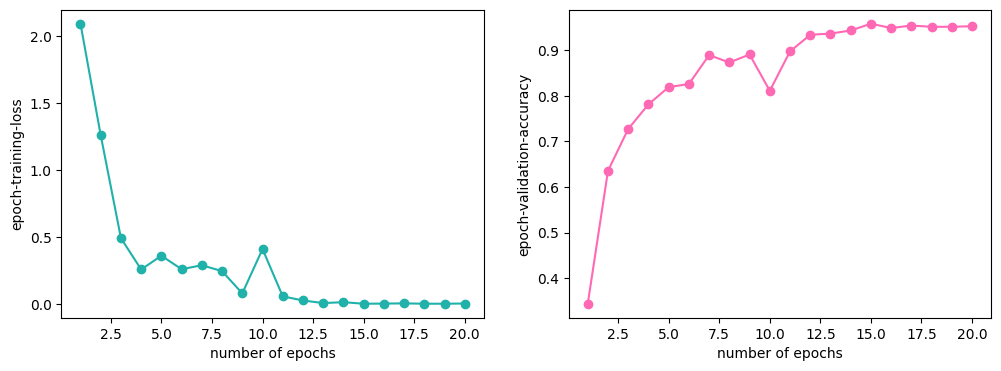

In [40]:
model.epochs_graphs()

some of the correct predictions in the testing dataset:-


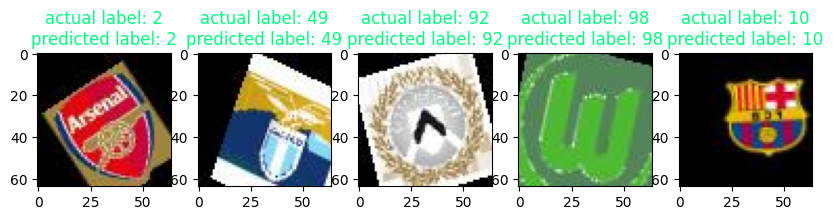

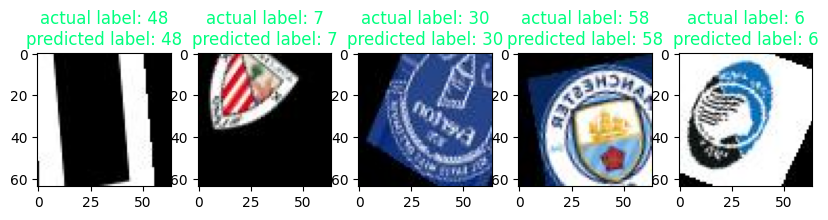

----------------------------------------------------------------------------------------------------
some of the incorrect predictions in the testing dataset:-


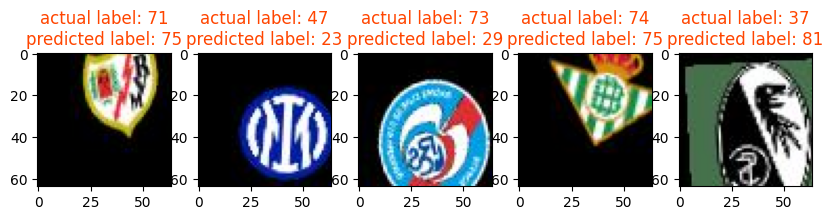

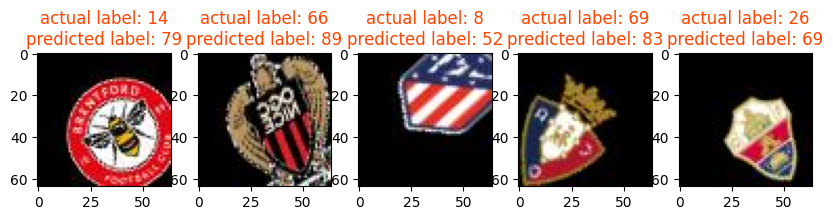

In [41]:
model.test_graph()

## ANN on grayscale images

In [42]:
model = MLP_PyTorch(num_input_nodes=IMG_SIZE*IMG_SIZE, num_hidden_nodes_1=256, num_hidden_nodes_2=256, num_output_nodes=100)

Number of trainable parameters:-
1048576
256
65536
256
25600
100


In [43]:
model.fit(train_dataloader_gray, val_dataloader_gray, learning_rate=0.0002, epochs=30)

epoch: 1, loss: 3.9808077812194824
validation accuracy: 0.05128205128205128
----------------------------------------------------------------------------------------------------
epoch: 2, loss: 3.8162732124328613
validation accuracy: 0.06072874493927125
----------------------------------------------------------------------------------------------------
epoch: 3, loss: 3.4906911849975586
validation accuracy: 0.08367071524966262
----------------------------------------------------------------------------------------------------
epoch: 4, loss: 3.5364160537719727
validation accuracy: 0.0931174089068826
----------------------------------------------------------------------------------------------------
epoch: 5, loss: 2.998194456100464
validation accuracy: 0.11605937921727395
----------------------------------------------------------------------------------------------------
epoch: 6, loss: 2.866360664367676
validation accuracy: 0.13630229419703105
------------------------------------------

In [44]:
model.test(test_dataloader_gray)

testing accuracy: 0.40652029274783763


---
# Random Forest Classifier
---

## Random Forest on RGB images

In [45]:
X_train_rgb = np.array([each[0].numpy().reshape(-1) for each in train_dataset])
y_train_rgb = np.array([each[1] for each in train_dataset])

X_test_rgb = np.array([each[0].numpy().reshape(-1) for each in test_dataset])
y_test_rgb = np.array([each[1] for each in test_dataset])

In [46]:
# Grid Search for Random Forest Classifier
'''
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_rgb, y_train_rgb)

print("best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(X_test_rgb)
accuracy_rf = (y_pred_rf == y_test_rgb).mean()
print("test accuracy:", accuracy_rf)
'''

# The optimal hyperparameters obtained after the Grid Search were:-
# -> max_depth = 20
# -> n_estimators = 200

print()

In [70]:
rf_model_rgb = RandomForestClassifier(max_depth = 20, n_estimators = 200)
rf_model_rgb.fit(X_train_rgb, y_train_rgb)
rf_model_rgb.score(X_test_rgb, y_test_rgb)

0.8057218895542249

## RandomForest on grayscale images

In [47]:
X_train_gray = np.array([x[0].numpy().reshape(-1) for x in train_dataset_gray])
y_train_gray = np.array([x[1] for x in train_dataset_gray])

X_test_gray = np.array([x[0].numpy().reshape(-1) for x in test_dataset_gray])
y_test_gray = np.array([x[1] for x in test_dataset_gray])

rf_model_gray = RandomForestClassifier(max_depth= 20, n_estimators= 200)
rf_model_gray.fit(X_train_gray, y_train_gray)
rf_model_gray.score(X_test_gray, y_test_gray)

0.677977378576181

---
# KNearestNeighbors Classfier (KNN)
---

In [48]:
# Grid Search for KNN

'''
param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
'''

# The optimal hyperparameters obtained after the Grid Search were:-
# -> n_neighbors = 3
# -> weights = 'distance'
# -> p = 1

print()

In [49]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)

In [50]:
knn.fit(X_train_rgb, y_train_rgb)
knn.score(X_test_rgb, y_test_rgb)

0.7225548902195609

---
# Convolutional Neural Network (CNN)
---

In [51]:
Xtrain_rgb = np.array([each[0].numpy() for each in train_dataset])
ytrain_rgb = np.array([each[1] for each in train_dataset])
Xtrain_rgb = tf.transpose(Xtrain_rgb, [0, 2, 3, 1])

Xtest_rgb = np.array([each[0].numpy() for each in test_dataset])
ytest_rgb = np.array([each[1] for each in test_dataset])
Xtest_rgb = tf.transpose(Xtest_rgb, [0, 2, 3, 1])

Xtrain_gray = np.array([each[0].numpy() for each in train_dataset_gray])
ytrain_gray = np.array([each[1] for each in train_dataset_gray])
Xtrain_gray = tf.transpose(Xtrain_gray, [0, 2, 3, 1])

Xtest_gray = np.array([each[0].numpy() for each in test_dataset_gray])
ytest_gray = np.array([each[1] for each in test_dataset_gray])
Xtest_gray = tf.transpose(Xtest_gray, [0, 2, 3, 1])

## CNN on RGB images

In [52]:
cnn_rgb = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(100, activation='softmax')
])

cnn_rgb.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
cnn_rgb.fit(Xtrain_rgb,ytrain_rgb, epochs=10)

Epoch 1/10
164/164 [==============================] - 10s 58ms/step - loss: 3.6507 - accuracy: 0.1483
Epoch 2/10
164/164 [==============================] - 9s 55ms/step - loss: 0.7636 - accuracy: 0.7619
Epoch 3/10
164/164 [==============================] - 9s 53ms/step - loss: 0.1875 - accuracy: 0.9454
Epoch 4/10
164/164 [==============================] - 9s 54ms/step - loss: 0.0989 - accuracy: 0.9715
Epoch 5/10
164/164 [==============================] - 9s 52ms/step - loss: 0.0568 - accuracy: 0.9849
Epoch 6/10
164/164 [==============================] - 8s 51ms/step - loss: 0.0966 - accuracy: 0.9700
Epoch 7/10
164/164 [==============================] - 8s 51ms/step - loss: 0.0307 - accuracy: 0.9929
Epoch 8/10
164/164 [==============================] - 8s 51ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 9/10
164/164 [==============================] - 8s 48ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/10
164/164 [==============================] - 8s 48ms/step - loss: 0.0011 - accur

In [54]:
cnn_rgb.evaluate(Xtest_rgb, ytest_rgb)

47/47 [==============================] - 1s 25ms/step - loss: 0.0590 - accuracy: 0.9807


[0.05899343639612198, 0.9807052612304688]

## CNN on grayscale images

In [55]:
cnn_gray = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(100, activation='softmax')
])

cnn_gray.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
cnn_gray.fit(Xtrain_gray, ytrain_gray, epochs=10)

Epoch 1/10
164/164 [==============================] - 8s 46ms/step - loss: 4.1054 - accuracy: 0.0602
Epoch 2/10
164/164 [==============================] - 8s 50ms/step - loss: 2.0017 - accuracy: 0.4253
Epoch 3/10
164/164 [==============================] - 8s 47ms/step - loss: 0.8506 - accuracy: 0.7384
Epoch 4/10
164/164 [==============================] - 8s 48ms/step - loss: 0.3735 - accuracy: 0.8926
Epoch 5/10
164/164 [==============================] - 8s 50ms/step - loss: 0.1998 - accuracy: 0.9452
Epoch 6/10
164/164 [==============================] - 8s 52ms/step - loss: 0.0755 - accuracy: 0.9861
Epoch 7/10
164/164 [==============================] - 8s 47ms/step - loss: 0.0494 - accuracy: 0.9903
Epoch 8/10
164/164 [==============================] - 9s 58ms/step - loss: 0.0663 - accuracy: 0.9841
Epoch 9/10
164/164 [==============================] - 9s 53ms/step - loss: 0.0618 - accuracy: 0.9857
Epoch 10/10
164/164 [==============================] - 9s 53ms/step - loss: 0.0230 - accura

In [57]:
cnn_gray.evaluate(Xtest_gray, ytest_gray)

47/47 [==============================] - 1s 25ms/step - loss: 0.4694 - accuracy: 0.8709


[0.4693657159805298, 0.8709248304367065]

---
# SVM Classifier
---

In [71]:
C_vals = [0.1, 1, 10,50]
gamma_vals = ['scale', 'auto']
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Performing Grid Search
'''
for i in range(len(kernels)):
    print(f'with kernel: {kernels[i]}')
    for j in range(len(gamma_vals)):
        for k in range(len(Cval)):
            svm_model=SVC(kernel=kernels[i], gamma=gamma_vals[j], C=C_vals[k])
            svm_model.fit(X_train,y_train)
            print(f'accuracy with gamma:{gamma_vals[j]}, c:{C_vals[k]} => {svm_model.score(X_test,y_test)}')
    print()
'''

# The optimal hyperparameters obtained after the grid search were:-
# -> kernel = 'rbf'
# -> gamma = 'auto'
# -> C = 50

print()

## SVM on RGB images

In [59]:
svm_model_rgb = SVC(kernel='rbf', gamma='scale', C=50)
svm_model_rgb.fit(X_train_rgb, y_train_rgb)
svm_model_rgb.score(X_test_rgb, y_test_rgb)

0.9021956087824351

## SVM on grayscale images

In [60]:
svm_model_gray = SVC(kernel='rbf', gamma='scale', C=50)
svm_model_gray.fit(X_train_gray, y_train_gray)
svm_model_gray.score(X_test_gray, y_test_gray)

0.633399866932801

---
# Other models (Failed Attempts)
---

## KMeans Algorithm

In [61]:
np.unique(y_train_rgb)
unique_ytrain_rgb = np.unique(y_train_rgb)

# finding centroids for all the classes and storing them in an array
init_centroid_array = np.empty((len(unique_ytrain_rgb), X_train_rgb.shape[1]))

for i, y in enumerate(unique_ytrain_rgb):
    Xy = X_train_rgb[y_train_rgb == y, :]
    centroid = np.mean(Xy, axis=0)
    init_centroid_array[i, :] = centroid

init_centroid_array

array([[0.16870287, 0.22669683, 0.25475115, ..., 0.12737557, 0.13461538,
        0.11199096],
       [0.04328809, 0.04389141, 0.04140272, ..., 0.00852187, 0.00286576,
        0.00279035],
       [0.07941177, 0.08521871, 0.09924586, ..., 0.02820513, 0.03182505,
        0.03167422],
       ...,
       [0.08748115, 0.07707392, 0.07586729, ..., 0.08348417, 0.08996984,
        0.08929113],
       [0.03861237, 0.03951735, 0.06515837, ..., 0.07360484, 0.06923079,
        0.06085974],
       [0.02404735, 0.02264151, 0.03070663, ..., 0.01080281, 0.01302257,
        0.01154273]])

In [62]:
# training the KMeans model by initializing the centroids of all the classes as the centroids
kmeansmodel = KMeans(n_clusters=100, init=init_centroid_array)
kmeansmodel.fit(X_train_rgb)

KMeans(init=array([[0.16870287, 0.22669683, 0.25475115, ..., 0.12737557, 0.13461538,
        0.11199096],
       [0.04328809, 0.04389141, 0.04140272, ..., 0.00852187, 0.00286576,
        0.00279035],
       [0.07941177, 0.08521871, 0.09924586, ..., 0.02820513, 0.03182505,
        0.03167422],
       ...,
       [0.08748115, 0.07707392, 0.07586729, ..., 0.08348417, 0.08996984,
        0.08929113],
       [0.03861237, 0.03951735, 0.06515837, ..., 0.07360484, 0.06923079,
        0.06085974],
       [0.02404735, 0.02264151, 0.03070663, ..., 0.01080281, 0.01302257,
        0.01154273]]),
       n_clusters=100)

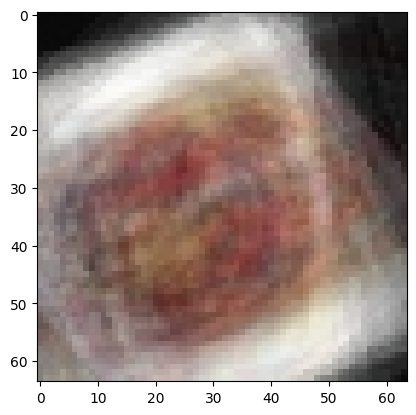

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


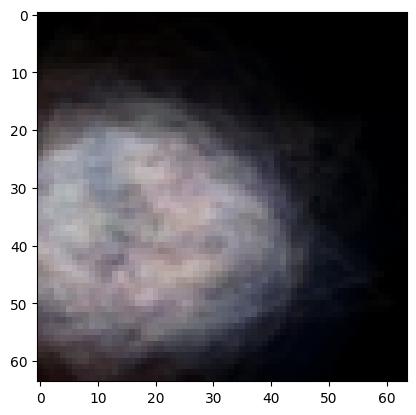

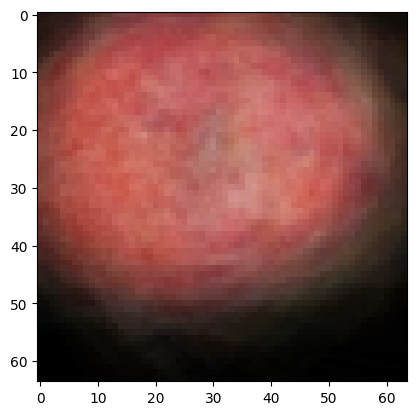

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


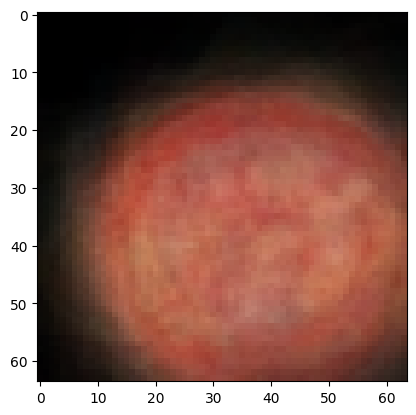

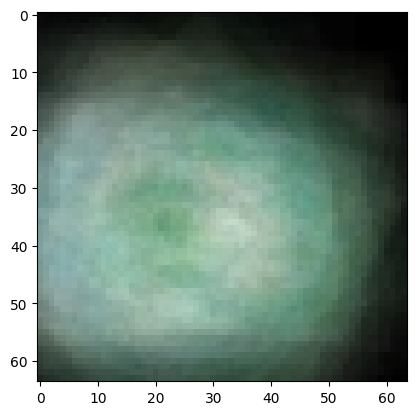

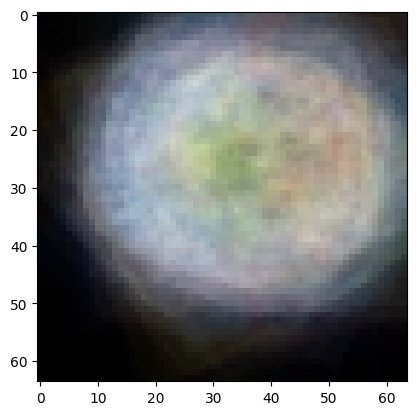

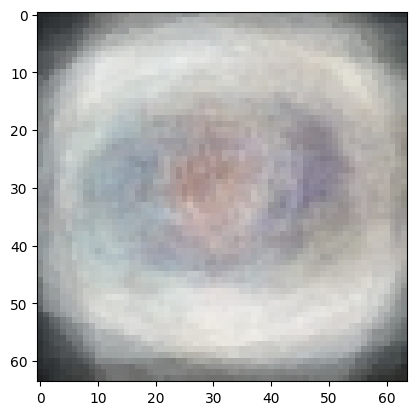

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


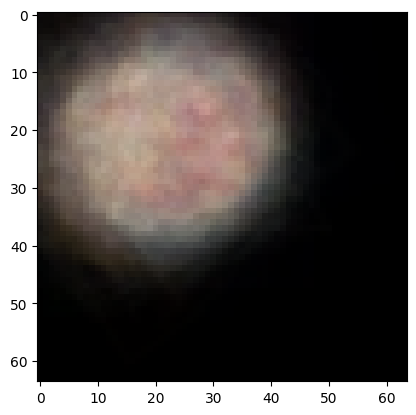

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


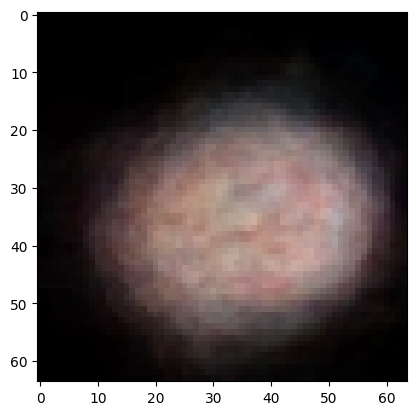

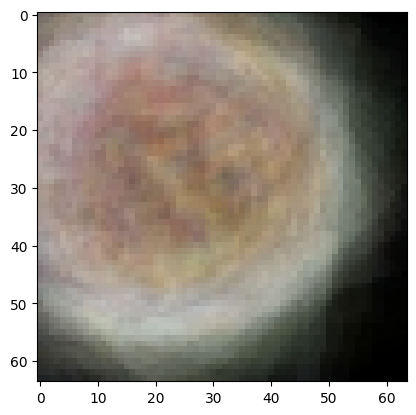

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


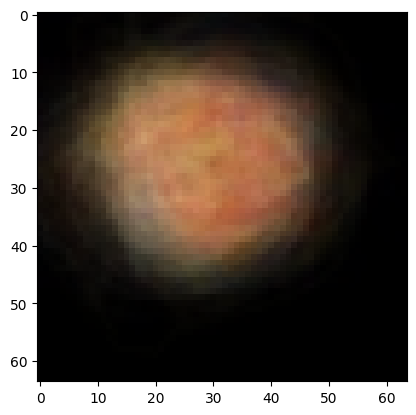

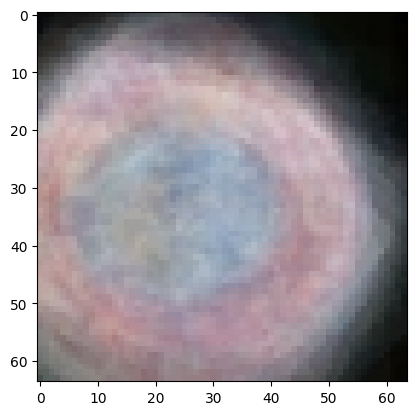

In [63]:
labels = kmeansmodel.labels_
centroids = kmeansmodel.cluster_centers_
unique_labels, label_counts = np.unique(labels, return_counts=True)

counter = 0

for centroid in centroids:
    plt.imshow((centroid.reshape(3,64,64).T))
    plt.show()
    
    if counter <= 10:
        counter += 1
    else:
        break

In [64]:
kmeans_pred = kmeansmodel.predict(X_test_rgb)
accuracy_score(y_test_rgb, kmeans_pred)

0.21756487025948104

---
# Making the final pipeline
---

In [65]:
def Pipeline(test_image_path):
    test_image = Image.open(test_image_path)
    
    # removing image background
    test_image = remove(test_image)
    
    # making the transparent background black
    black_background_image = Image.new('RGB', test_image.size, (0,0,0))
    black_background_image.paste(test_image, mask=test_image)
    
    # resizing the image
    test_image = img_to_array(black_background_image)
    resized_test_image = cv2.resize(test_image, (IMG_SIZE, IMG_SIZE))
    final_test_image = transform(resized_test_image)
    
    dim1, dim2, dim3 = final_test_image.shape
    final_test_image = final_test_image.reshape(1, dim1, dim2, dim3) 
    
    final_test_image = final_test_image.to(torch.float32)
    final_test_image = final_test_image.numpy()
    final_test_image = tf.transpose(final_test_image, [0, 2, 3, 1])

    prediction = cnn_rgb.predict(final_test_image)[0]
    result = classes_reverse_dict[np.argmax(prediction)]
    
    return result

# Testing the pipeline on an image not from the dataset

In [66]:
for each in os.listdir('test-images'):
    print(f'Entered image: {each}')
    print(f'Predicted team: {Pipeline("test-images/" + each)}')
    print()

Entered image: test-angers-1.png
1/1 [==============================] - 0s 74ms/step
Predicted team: angers-sco

Entered image: test-arsenal-1.png
1/1 [==============================] - 0s 24ms/step
Predicted team: arsenal

Entered image: test-atletico-madrid-2.png
1/1 [==============================] - 0s 19ms/step
Predicted team: athletic

Entered image: test-barcelona-1.png
1/1 [==============================] - 0s 17ms/step
Predicted team: barcelona

Entered image: test-barcelona-2.jpg
1/1 [==============================] - 0s 19ms/step
Predicted team: barcelona

Entered image: test-barcelona-3.jpeg
1/1 [==============================] - 0s 27ms/step
Predicted team: barcelona

Entered image: test-bayern-1.png
1/1 [==============================] - 0s 17ms/step
Predicted team: bayern

Entered image: test-bayern-2.jpg
1/1 [==============================] - 0s 20ms/step
Predicted team: losc-lille

Entered image: test-chelsea-1.png
1/1 [==============================] - 0s 17ms/step
Pr

# Saving the best classifier model

In [72]:
# cnn_rgb.save('model')